<a href="https://colab.research.google.com/github/fedhere/MLTSA_FBianco/blob/master/HW1/FittingLineToGRBAfterglows_TrainTestSplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods. 

Notes: 

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [1]:
import pandas as pd
import pylab as pl
%pylab inline

# I have created a stylesheet to define default plot behaviors. 
# This stylesheet changes the default parameters stored in the dictionary matplitlib.rcParams
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [2]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/HW1/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [3]:
grbAG.time

0           66
1           67
2           68
3           69
4           70
        ...   
114      63738
115      74798
116     128928
117     971360
118    1171176
Name: time, Length: 119, dtype: int64

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [4]:
grbAG["logtime"] = np.log10(grbAG.time)
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B. 

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


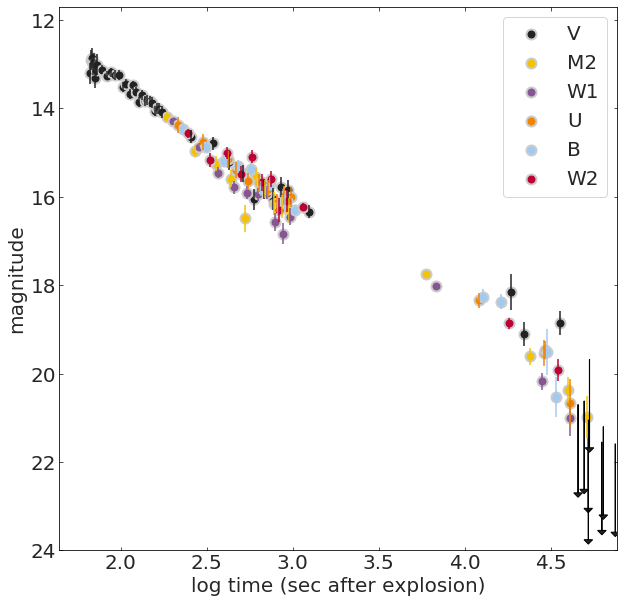

In [5]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
#loop on every filter to plot - this will give differnt colors naturally. 
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)
    
# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')
    

# plot the upperlimits as arrows
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)          
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows. 

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [0]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values
#note the shape in python is flipped compared to the shape in linear algebra

# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


# split training and test set (incorrectly!)

In [0]:
x_train, x_test, y_train, y_test, s_train, s_test = x[:75], x[75:], y[:75], y[75:], s[:75], s[75:]


# Fit a line to the data (excluding the upper limits) by minimizing an objective function on the training set. test it on the test set

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [0]:
#define utility functions

def line(x, intercept, slope):
    return slope * x + intercept

def chi2(args, x, y, s):
  
    a, b = args
    return sum((y - line(x, a, b))**2 / s)

def Rsquare(args, x, y):
    a, b = args
    return 1 - (1 / x.shape[0]) * sum((y - line(x, a, b))**2) / np.std(y)**2


In [0]:
def plotline(pars, x, color='k', symbol='-', label='model', ax=ax):
    slope, intercept = pars
    y = line(x, intercept, slope)
    ax.plot(x, y, ls=symbol, c=color, label=label)

def plotdatapoints(x_train, y_train, s_train, x_test, y_test, s_test, linepars=None):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
  #Use pl.errorbar to plot the uncertainties

  pl.errorbar(x_train, y_train, s_train, fmt='.', ms=0,
                fcolor=None, label=None, color='SteelBlue')
    
  pl.errorbar(x_test, y_test, s_test, fmt='.', ms=0,
                fcolor=None, label=None, color='IndianRed')

  pl.scatter(x_train, y_train,  
             s=100, alpha=1, linewidth=2, 
             label="training", color='SteelBlue')

  pl.scatter(x_test, y_test,
            alpha=1, s=100, linewidth=2,
           label="testing", color='IndianRed')    

  if not linepars is None:
    plotline(linepars[:2], linepars[2], ax=ax, label=linepars[3])
    

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  pl.ylim(24,11.7)          
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time (sec after explosion)", fontsize=20);
  return ax



      fun: 17.521794221584113
 hess_inv: array([[ 0.05027458, -0.02065712],
       [-0.02065712,  0.00865753]])
      jac: array([0.00000000e+00, 4.05311584e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([7.50100248, 2.96127966])

best fit parameters from the minimization of the chi squared: slope 7.50, intercept 2.96
R square on training set:  0.9630118899499893
R square on test set:  0.7220141765252428


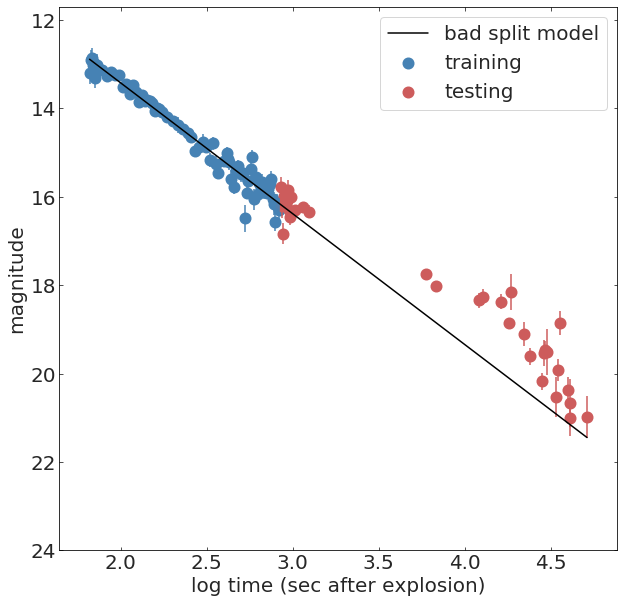

In [15]:
import scipy
from scipy.optimize import minimize

initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x_train, y_train, s_train))
plotdatapoints(x_train, y_train, s_train, x_test, y_test, s_test, linepars=(*chi2Solution.x[::-1], x, "bad split model"))

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

print("R square on training set: ", Rsquare(chi2Solution.x, x_train, y_train))
print("R square on test set: ", Rsquare(chi2Solution.x, x_test, y_test))

# splitting data properly

In [0]:
import sklearn
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(
     x, y, s, test_size=0.25, random_state=42)



      fun: 45.757450164460586
 hess_inv: array([[ 0.01377532, -0.00459257],
       [-0.00459257,  0.00164512]])
      jac: array([0.00000000e+00, 9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([8.66427997, 2.46972727])

best fit parameters from the minimization of the chi squared: slope 8.66, intercept 2.47
R square on training set:  0.9713830346398566
R square on test set:  0.968121255865108


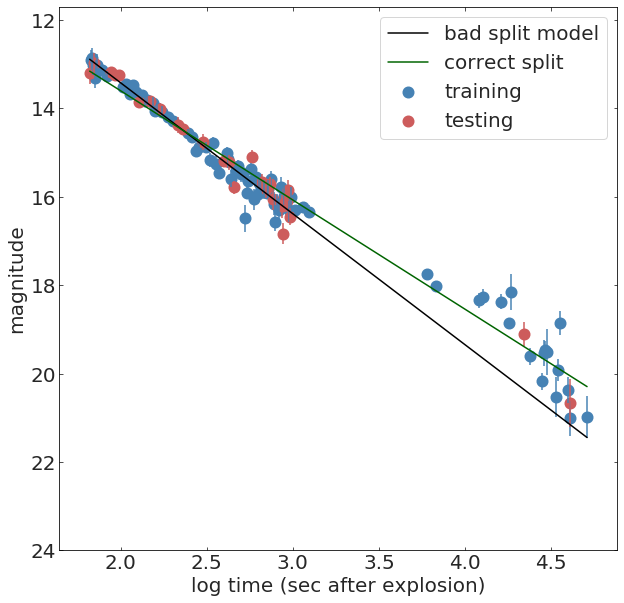

In [0]:
ax = plotdatapoints(x_train, y_train, s_train, x_test, y_test, s_test, 
                    linepars=(*chi2Solution.x[::-1], x, "bad split model"))

initialGuess = (10, 1)

chi2Solution_goodsplit = minimize(chi2, initialGuess, args=(x_train, y_train, s_train))

plotline(chi2Solution_goodsplit.x[::-1], x, color='DarkGreen', ax=ax, label='correct split')
pl.legend()


print(chi2Solution_goodsplit)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution_goodsplit.x))

print("R square on training set: ", Rsquare(chi2Solution_goodsplit.x, x_train, y_train))
print("R square on test set: ", Rsquare(chi2Solution_goodsplit.x, x_test, y_test))